In [18]:
import os
import sys
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

notebook_dir = %pwd
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.utils import create_train_test

In [19]:
f_path = os.path.join(notebook_dir, "..", "data", "raw", "features_3_sec.csv")
# f_path = os.path.join(notebook_dir, "..", "data", "raw", "features_30_sec.csv")

df = pd.read_csv(f_path)  # shape (9990, 60) for 3_sec

FEATURES = list(df.columns)[2:-1]

In [30]:
X_train, X_test, y_train, y_test = create_train_test(df)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

test_predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, test_predictions)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.87


MODELS:

- baselineRandomForest (n_estimators=100, random_state=42), trained on vanilla GTZAN dataset without feature selection/engineering; achieves accuracy of 88% on the test set

In [31]:
joblib.dump(model, "baselineRandomForest.joblib")

['baselineRandomForest.joblib']

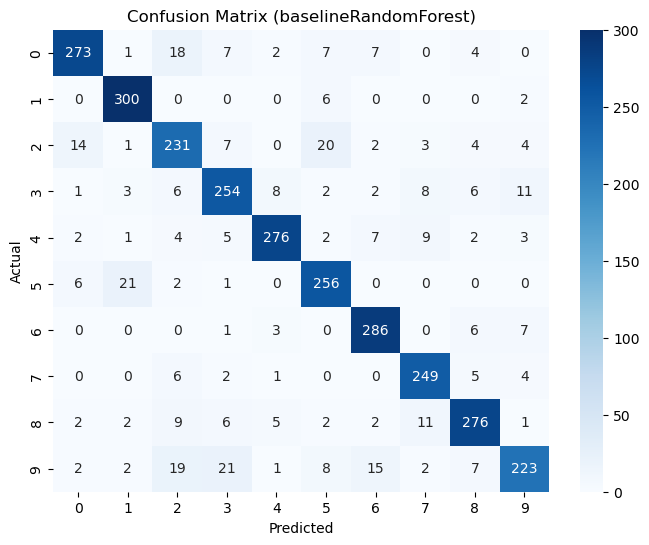

In [7]:
# baselineRandomForest confusion matrix

conf_mat = confusion_matrix(y_test, test_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix (baselineRandomForest)")

eval_dir = os.path.join("..", "models", "evaluation", "baselineRandomForest")
plot_path = os.path.join(eval_dir, "confusion_matrix.png")
plt.savefig(plot_path)

plt.show()
plt.close()

In [9]:
# baselineRandomForest classification report
report = classification_report(y_test, test_predictions)
print("Classification report:")
print(report)

report_file_path = os.path.join(
    notebook_dir,
    "..",
    "models",
    "evaluation",
    "baselineRandomForest",
    "classification_report.txt",
)
with open(report_file_path, "w") as file:
    file.write(report)

Classification report:
              precision    recall  f1-score   support

       blues       0.91      0.86      0.88       319
   classical       0.91      0.97      0.94       308
     country       0.78      0.81      0.80       286
       disco       0.84      0.84      0.84       301
      hiphop       0.93      0.89      0.91       311
        jazz       0.84      0.90      0.87       286
       metal       0.89      0.94      0.92       303
         pop       0.88      0.93      0.91       267
      reggae       0.89      0.87      0.88       316
        rock       0.87      0.74      0.80       300

    accuracy                           0.88      2997
   macro avg       0.88      0.88      0.87      2997
weighted avg       0.88      0.88      0.87      2997



In [13]:
# hyperparameter optimization via random search

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

param_dist = {
    "n_estimators": randint(100, 500),
    "max_depth": [10, 20, 30, 40],
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 5),
    "max_features": ["sqrt", "log2"],
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42,
)
random_search.fit(X_train, y_train)

print(f"Best Parameters: {random_search.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=199; total time=  17.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=199; total time=  17.4s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=9, n_estimators=288; total time=  20.7s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=9, n_estimators=288; total time=  20.7s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=9, n_estimators=288; total time=  20.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=314; total time=  25.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=314; total time=  25.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=314

In [15]:
# updated RandomForestClassifier model based on hyperparameter optimization

updated_model = RandomForestClassifier(
    n_estimators=413,
    max_depth=40,
    max_features="log2",
    min_samples_leaf=1,
    min_samples_split=2,
)

updated_model.fit(X_train, y_train)

y_pred = updated_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(
    f"Accuracy: {accuracy:.2f}"
)  # accuracy is 0.87 - essentially the same as baseline

Accuracy: 0.87


In [16]:
# feature selection

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
percentile_importance = np.percentile(importances, 75)
cutoff = percentile_importance
selected_features = indices[importances[indices] >= cutoff]
print(selected_features)
# selected_features = np.array([15, 2, 3, 0, 23, 6, 14, 13, 8, 17, 18, 33, 9, 5, 27])

[15  2  3  0 23  6 14 13  8 17 18 33  9  5 27]


In [89]:
# ------------- CONCATENATION -------------
full_probabilities = model.predict_proba(X)
genres = [
    "blues",
    "classical",
    "country",
    "disco",
    "hiphop",
    "jazz",
    "metal",
    "pop",
    "reggae",
    "rock",
]
ids = df.iloc[::10, 0].to_numpy()
ids = np.expand_dims(ids, 1)
for i in range(len(ids[0])):
    parts = ids[i][0].split(".")
    ids[i][0] = parts[0] + "." + parts[1] + "." + parts[3]
y = np.expand_dims(y, 1)

data = np.hstack((ids, full_probabilities, y))

column_names = ["track_id"] + genres + ["true_labels"]
updated_df = pd.DataFrame(data, columns=column_names)

updated_df.to_csv(
    path_or_buf=os.path.join(
        notebook_dir, "..", "data", "updated_track_probabilities.csv"
    ),
    index=False,
)

In [29]:
# ---------------- VALIDATION ----------------
validation_path = os.path.join(
    notebook_dir, "..", "data", "external", "validation_set.csv"
)
df_val = pd.read_csv(validation_path)

# X_val = df_val.iloc[:, 1:-1].to_numpy()  # including the singing files
# y_val = df_val.iloc[:, -1].to_numpy()

X_val = df_val.iloc[30:, 1:-1].to_numpy()  # excluding the singing files
y_val = df_val.iloc[30:, -1].to_numpy()

val_predictions = model.predict(X_val)
accuracy = accuracy_score(y_val, val_predictions)
print(f"Accuracy: {accuracy:.2f}")
# print(df_val.iloc[val_predictions != y_val, 0][30:60])
# print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.26
